# single-cell Progeny Production analysis
This notebook provides a central place to integrate and analyze transcriptome and progeny production data.

## Notebook setup
Import python modules:

In [1]:
from IPython.display import display

from dms_variants.constants import CBPALETTE

import pandas as pd

import plotnine as p9

import scipy

import statsmodels.stats.multitest

Hardcode input data for this analysis.

In [2]:
viral_tag_by_cell_csv = 'results/viral_tags_bcs_in_cells/scProgenyProduction_trial3_cell_barcodes_with_viral_tags.csv.gz'
viral_bc_background_freq_csv = 'results/viral_fastq10x/scProgenyProduction_trial3_viral_bc_background_freq.csv.gz'
viral_bc_in_progeny_freq_csv = 'results/viral_progeny/scProgenyProduction_trial3_viral_bc_in_progeny_freq.csv.gz'
expt = 'scProgenyProduction_trial3'
plot = 'results/viral_fastq10x/scProgenyProduction_trial3_viral_bc_correlations.pdf'
barcoded_viral_genes = ['fluHA', 'fluNA']

Set plotnine theme

In [3]:
p9.theme_set(p9.theme_classic())

## Correlation between transcripts and progeny
This section plots the correlation between viral barcode expression in the transcriptome and viral barcode fraction in the progeny datasets (supernatant or second infection).

### Organize data
First, read the cell barcodes and tags into a pandas dataframe. Only keep relevant columns.

In [4]:
all_cells = pd.read_csv(viral_tag_by_cell_csv)
all_cells = all_cells[['cell_barcode',
                       'infected',
                       'infecting_viral_tag']]
display(all_cells)

,cell_barcode,infected,infecting_viral_tag
0,AAACCCAGTAACAAGT,False,none
1,AAACCCATCATTGCTT,False,none
2,AAACGAAAGATGTTGA,False,none
3,AAACGAAGTACTTCCC,True,wt
4,AAACGAAGTAGACGTG,True,wt
...,...,...,...
3360,TTTGATCTCCCGTTCA,False,none
3361,TTTGATCTCGCATTGA,True,wt
3362,TTTGGAGAGTTGCCTA,False,none
3363,TTTGGAGGTATCGTTG,True,wt


Next, read the viral barcode frequencies from the transcriptome.

In [5]:
transcriptome_viral_bc_freqs = pd.read_csv(viral_bc_background_freq_csv)
assert set(transcriptome_viral_bc_freqs['gene']) == set(barcoded_viral_genes), \
       "Barcoded genes in barcode counts do not match expectation."
display(transcriptome_viral_bc_freqs)

,cell_barcode,infected,infecting_viral_tag,gene,viral_barcode,frac_viral_bc_UMIs,reject_uninfected
0,AAACCCAGTAACAAGT,False,none,fluHA,NaN,0.000000,False
1,AAACCCATCATTGCTT,False,none,fluHA,NaN,0.000000,False
2,AAACGAAAGATGTTGA,False,none,fluHA,NaN,0.000000,False
3,AAACGAAGTACTTCCC,True,wt,fluHA,NaN,0.000000,False
4,AAACGAAGTAGACGTG,True,wt,fluHA,AAGTAAGCGACATGAG,0.001271,True
...,...,...,...,...,...,...,...
7706,TTTGATCTCCCGTTCA,False,none,fluNA,NaN,0.000000,False
7707,TTTGATCTCGCATTGA,True,wt,fluNA,NaN,0.000000,False
7708,TTTGGAGAGTTGCCTA,False,none,fluNA,NaN,0.000000,False
7709,TTTGGAGGTATCGTTG,True,wt,fluNA,ACATCTTATTTACACG,0.000349,False


Read the viral barcode frequencies from the progeny. **For now just work with supernatant data. Remove second_infection frequencies.**

In [6]:
progeny_viral_bc_freqs = pd.read_csv(viral_bc_in_progeny_freq_csv)
assert set(progeny_viral_bc_freqs['gene']) == set(barcoded_viral_genes), \
       "Barcoded genes in barcode counts do not match expectation."
progeny_viral_bc_freqs = (progeny_viral_bc_freqs
                          .rename(columns={'barcode': 'viral_barcode',
                                           'tag': 'infecting_viral_tag',
                                           'mean_freq': 'freq_progeny'}))
progeny_viral_bc_freqs = (progeny_viral_bc_freqs
                          .query('source == "supernatant"'))
progeny_viral_bc_freqs = progeny_viral_bc_freqs.drop(columns = 'source')
display(progeny_viral_bc_freqs)

,infecting_viral_tag,gene,viral_barcode,freq_progeny
0,syn,fluHA,AAAAAAGCACGAGCAG,2.507618e-07
1,syn,fluHA,AAAAAATCCTTCAGCA,2.574453e-07
2,syn,fluHA,AAAAAATGGCGACGCT,2.574453e-07
3,syn,fluHA,AAAAAATTGGTTTACT,2.574453e-07
4,syn,fluHA,AAAAACACTCACAAGT,2.574453e-07
...,...,...,...,...
57485,wt,fluNA,TTTTTCCCTTACATAT,4.799773e-07
57486,wt,fluNA,TTTTTCTTACGATCAC,4.799773e-07
57487,wt,fluNA,TTTTTCTTCGAGATAG,4.799773e-06
57488,wt,fluNA,TTTTTGGGATCATTGC,9.599545e-07


Merge dataframes to one. This will be done in two steps. First, merge transcriptome frequencies with all cells tag info.  Then, merge supernatant frequencies into this dataframe.

Structure of the final dataframe should be as follows:
1. Cell barcode
2. Infected
3. Infecting viral tag
4. Gene
5. Viral barcode
6. Frequency in transcriptome (`frac_viral_bc_UMIs`)
7. Frequency in supernatant sequencing (`freq_progeny`)

In [7]:
viral_bc_freqs = pd.merge(
    left=pd.concat([all_cells.assign(gene=gene)
                    for gene in barcoded_viral_genes]),
    right=transcriptome_viral_bc_freqs,
    how='outer',
    on=['cell_barcode', 'gene', 'infected', 'infecting_viral_tag'],
    validate='one_to_many')

assert (viral_bc_freqs['cell_barcode'].unique() ==
        all_cells['cell_barcode'].unique()).all(), \
       "Cell barcodes in merged dataframe don't " \
       "match barcodes in source data."
assert (viral_bc_freqs['viral_barcode'].nunique() ==
        transcriptome_viral_bc_freqs['viral_barcode'].nunique()), \
       "Number of viral barcodes in merged dataframe doesn't " \
       "match number of barcodes in source data."

viral_bc_freqs = pd.merge(
    left=viral_bc_freqs,
    right=progeny_viral_bc_freqs,
    how='outer',
    on=['viral_barcode', 'gene', 'infecting_viral_tag'])
# Need to think of what asserts to include here

display(viral_bc_freqs)

,cell_barcode,infected,infecting_viral_tag,gene,viral_barcode,frac_viral_bc_UMIs,reject_uninfected,freq_progeny
0,AAACCCAGTAACAAGT,False,none,fluHA,NaN,0.0,False,NaN
1,AAACCCATCATTGCTT,False,none,fluHA,NaN,0.0,False,NaN
2,AAACGAAAGATGTTGA,False,none,fluHA,NaN,0.0,False,NaN
3,AAACGAAGTGATAGAT,False,none,fluHA,NaN,0.0,False,NaN
4,AAACGCTCAAATGATG,False,none,fluHA,NaN,0.0,False,NaN
...,...,...,...,...,...,...,...,...
64902,NaN,NaN,wt,fluNA,TTTTTCCCTTACATAT,NaN,NaN,4.799773e-07
64903,NaN,NaN,wt,fluNA,TTTTTCTTACGATCAC,NaN,NaN,4.799773e-07
64904,NaN,NaN,wt,fluNA,TTTTTCTTCGAGATAG,NaN,NaN,4.799773e-06
64905,NaN,NaN,wt,fluNA,TTTTTGGGATCATTGC,NaN,NaN,9.599545e-07


## Filtering
**I am not doing any filtering on this data yet. I will plot the data in its raw form first.**

*Potential filtering strategy in future:*
>I will need to filter these data further before plotting. Here are the parameters I am using:
>1. Only look at cells called as infected.
>2. Only keep viral barcodes found in the transcriptome data, since these are the ones we can probe further in the transcriptome.
>3. Only look at viral barcodes called as significantly higher frequency than background (`reject_uninfected == True`)

### Plots

#### Viral transcription
***Note:*** `NA` values (0 counts) in the transcriptome data are plotted on the far left side of this graph at `1e-8`.

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_bin : Removed 5596 rows containing non-finite values.
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it


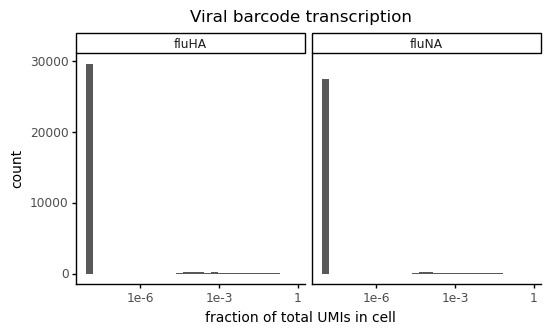

<ggplot: (8740440658493)>

In [8]:
fig = (p9.ggplot(viral_bc_freqs.fillna(1e-8),
                 p9.aes(x='frac_viral_bc_UMIs')) +
       p9.geom_histogram(bins=30) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'Viral barcode transcription') +
       p9.scale_x_log10() +
       p9.labs(x='fraction of total UMIs in cell') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center') +
       p9.scale_fill_manual(CBPALETTE[0:]))
display(fig)

Without the `NA` values:

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_bin : Removed 5596 rows containing non-finite values.
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it


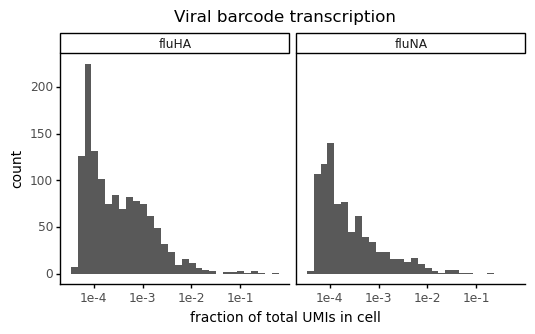

<ggplot: (8740441925199)>

In [9]:
fig = (p9.ggplot(viral_bc_freqs.query('frac_viral_bc_UMIs.notnull()', engine='python'),
                 p9.aes(x='frac_viral_bc_UMIs')) +
       p9.geom_histogram(bins=30) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'Viral barcode transcription') +
       p9.scale_x_log10() +
       p9.labs(x='fraction of total UMIs in cell') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center') +
       p9.scale_fill_manual(CBPALETTE[0:]))
display(fig)

#### Supernatant progeny production
***Note:*** `NA` values (0 counts) in the supernatant data are plotted on the far left side of this graph at `1e-8`.

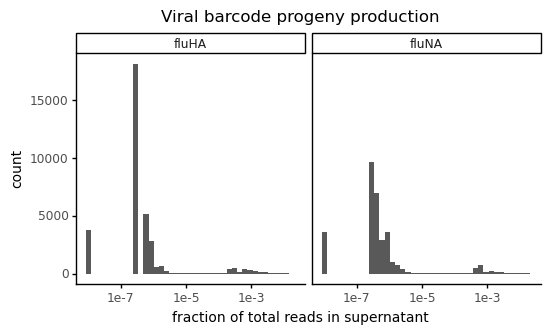

<ggplot: (8740440574431)>

In [10]:
fig = (p9.ggplot(viral_bc_freqs.fillna(1e-8),
                 p9.aes(x='freq_progeny')) +
       p9.geom_histogram(bins=40) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'Viral barcode progeny production') +
       p9.labs(x='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center') +
       p9.scale_x_log10())
display(fig)

Without the 0 values:

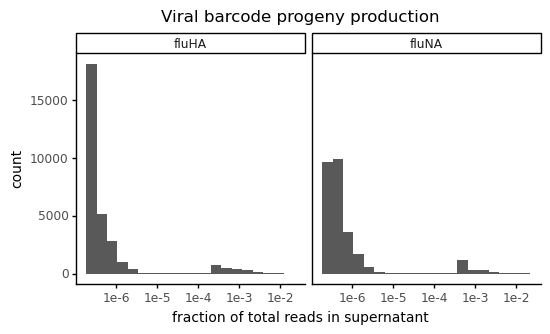

<ggplot: (8740440517973)>

In [11]:
fig = (p9.ggplot(viral_bc_freqs.query('freq_progeny.notnull()', engine='python'),
                 p9.aes(x='freq_progeny')) +
       p9.geom_histogram(bins=20) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'Viral barcode progeny production') +
       p9.labs(x='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center') +
       p9.scale_x_log10())
display(fig)

#### Correlation of viral transcription and progeny production

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


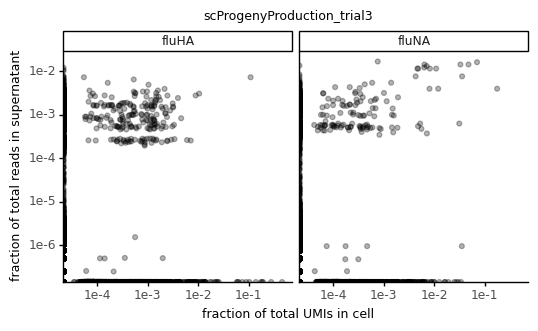

<ggplot: (8740436952902)>

In [12]:
fig = (p9.ggplot(viral_bc_freqs.fillna(0),
                 p9.aes(x='frac_viral_bc_UMIs',
                        y='freq_progeny')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='fraction of total UMIs in cell',
               y='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)

Export correlation plot:

In [13]:
print(f"Saving correlation plot to {plot}")
p9.ggsave(plot=fig, filename=plot, verbose=False)

Saving correlation plot to results/viral_fastq10x/scProgenyProduction_trial3_viral_bc_correlations.pdf


/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


## Annotating plot

### Infected

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


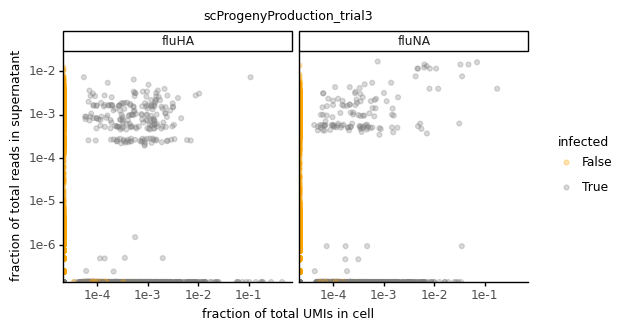

<ggplot: (8740436876493)>

In [14]:
fig = (p9.ggplot(viral_bc_freqs.fillna(0),
                 p9.aes(x='frac_viral_bc_UMIs',
                        y='freq_progeny',
                        color='infected')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='fraction of total UMIs in cell',
               y='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['orange','grey']))
display(fig)

### Variant

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


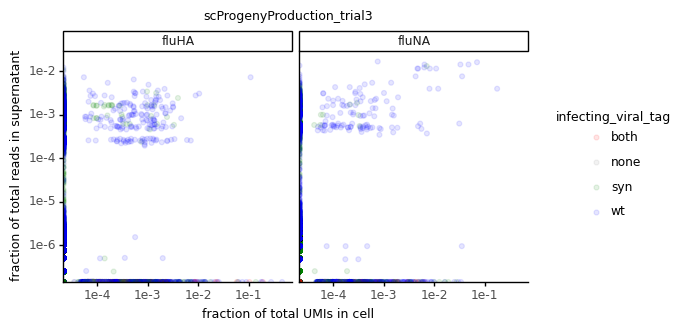

<ggplot: (8740436279836)>

In [15]:
fig = (p9.ggplot(viral_bc_freqs.fillna(0),
                 p9.aes(x='frac_viral_bc_UMIs',
                        y='freq_progeny',
                        color='infecting_viral_tag')) +
       p9.geom_point(alpha=0.1) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='fraction of total UMIs in cell',
               y='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['red','grey','green','blue']))
display(fig)

### Above background frequency

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


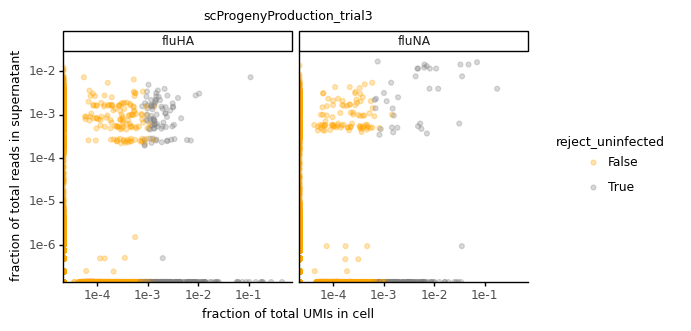

<ggplot: (8740440401330)>

In [16]:
fig = (p9.ggplot(viral_bc_freqs.fillna(0),
                 p9.aes(x='frac_viral_bc_UMIs',
                        y='freq_progeny',
                        color='reject_uninfected')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='fraction of total UMIs in cell',
               y='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['orange','grey']))
display(fig)

### Cells per viral barcode
I want to annotate viral barcodes that are found above background in multiple cells. This should be very unlikely in a low MOI infection.

Calculate the number of cells each viral barcode is found in:

In [17]:
n_cell_bc = (viral_bc_freqs
             .query('(reject_uninfected == True) and '
                    '(cell_barcode.notna())',
                    engine='python')
             .groupby(['infecting_viral_tag',
                       'gene',
                       'viral_barcode',
                       'reject_uninfected'])
             ['cell_barcode']
             .nunique()
             .reset_index()
             .rename(columns={'cell_barcode': 'n_cell_bc'}))

n_cell_bc

viral_bc_freqs = pd.merge(
    viral_bc_freqs,
    n_cell_bc,
    on=['infecting_viral_tag',
        'gene',
        'viral_barcode',
        'reject_uninfected'],
    how='left')

viral_bc_freqs

,cell_barcode,infected,infecting_viral_tag,gene,viral_barcode,frac_viral_bc_UMIs,reject_uninfected,freq_progeny,n_cell_bc
0,AAACCCAGTAACAAGT,False,none,fluHA,NaN,0.0,False,NaN,NaN
1,AAACCCATCATTGCTT,False,none,fluHA,NaN,0.0,False,NaN,NaN
2,AAACGAAAGATGTTGA,False,none,fluHA,NaN,0.0,False,NaN,NaN
3,AAACGAAGTGATAGAT,False,none,fluHA,NaN,0.0,False,NaN,NaN
4,AAACGCTCAAATGATG,False,none,fluHA,NaN,0.0,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...
64902,NaN,NaN,wt,fluNA,TTTTTCCCTTACATAT,NaN,NaN,4.799773e-07,NaN
64903,NaN,NaN,wt,fluNA,TTTTTCTTACGATCAC,NaN,NaN,4.799773e-07,NaN
64904,NaN,NaN,wt,fluNA,TTTTTCTTCGAGATAG,NaN,NaN,4.799773e-06,NaN
64905,NaN,NaN,wt,fluNA,TTTTTGGGATCATTGC,NaN,NaN,9.599545e-07,NaN


Plot distribution of cell barcode per viral barcode. Only look at viral barcodes found above background and present in the transcriptome.

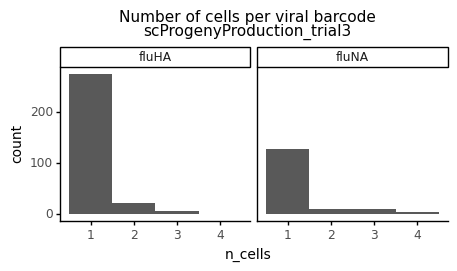

<ggplot: (8740436911773)>

In [18]:
fig = (p9.ggplot(viral_bc_freqs
                 .query('(reject_uninfected == True) and '
                        '(cell_barcode.notna())',
                        engine='python')) +
       p9.geom_histogram(p9.aes(x='n_cell_bc'),
                         binwidth=1,
                         position='dodge') +
       p9.facet_grid('~gene') +
       p9.ggtitle('Number of cells per viral barcode\n'
                  f'{expt}') +
       p9.xlab('n_cells') +
       p9.theme(figure_size=(5, 2),
                plot_title=p9.element_text(size=11),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

Now I will label viral barcodes that are found in more than 1 cells.

In [19]:
viral_bc_freqs['gt1_cell'] = (
    viral_bc_freqs['n_cell_bc'] > 1)

viral_bc_freqs

,cell_barcode,infected,infecting_viral_tag,gene,viral_barcode,frac_viral_bc_UMIs,reject_uninfected,freq_progeny,n_cell_bc,gt1_cell
0,AAACCCAGTAACAAGT,False,none,fluHA,NaN,0.0,False,NaN,NaN,False
1,AAACCCATCATTGCTT,False,none,fluHA,NaN,0.0,False,NaN,NaN,False
2,AAACGAAAGATGTTGA,False,none,fluHA,NaN,0.0,False,NaN,NaN,False
3,AAACGAAGTGATAGAT,False,none,fluHA,NaN,0.0,False,NaN,NaN,False
4,AAACGCTCAAATGATG,False,none,fluHA,NaN,0.0,False,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...
64902,NaN,NaN,wt,fluNA,TTTTTCCCTTACATAT,NaN,NaN,4.799773e-07,NaN,False
64903,NaN,NaN,wt,fluNA,TTTTTCTTACGATCAC,NaN,NaN,4.799773e-07,NaN,False
64904,NaN,NaN,wt,fluNA,TTTTTCTTCGAGATAG,NaN,NaN,4.799773e-06,NaN,False
64905,NaN,NaN,wt,fluNA,TTTTTGGGATCATTGC,NaN,NaN,9.599545e-07,NaN,False


Plot number of viral barcodes that were found in more than 1 cell:

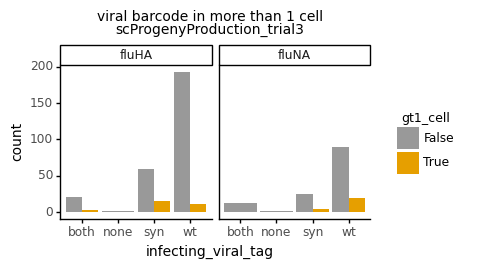

<ggplot: (8740440453337)>

In [20]:
output_fig = (p9.ggplot((viral_bc_freqs
                         .query('(reject_uninfected == True) and '
                                '(cell_barcode.notna())',
                                engine='python')),
                        p9.aes(x='infecting_viral_tag',
                               fill='gt1_cell')) +
              p9.geom_bar(stat='count', position='dodge') +
              p9.ggtitle('viral barcode in more than 1 cell\n'
                         f'{expt}') +
              p9.facet_grid('~gene') +
              p9.theme(figure_size=(4, 2),
                       plot_title=p9.element_text(size=10),
                       axis_title=p9.element_text(size=10),
                       legend_title=p9.element_text(size=9),
                       legend_title_align='center') +
              p9.scale_fill_manual(CBPALETTE[0:]))
display(output_fig)

Plot transcript-supernatant correlation with this info annotated:

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


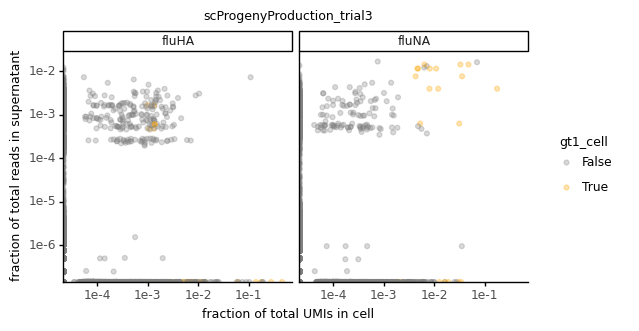

<ggplot: (8740440457906)>

In [21]:
fig = (p9.ggplot(viral_bc_freqs.fillna(0),
                 p9.aes(x='frac_viral_bc_UMIs',
                        y='freq_progeny',
                        color='gt1_cell')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='fraction of total UMIs in cell',
               y='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['grey','orange']))
display(fig)

### Viral barcodes per cell
I want to annotate cells with the number of viral barcodes above background on each segment.

Calculate the number of viral barcodes each segment has per cell:

In [22]:
n_viral_bc = (viral_bc_freqs
             .query('(reject_uninfected == True) and '
                    '(cell_barcode.notna())',
                    engine='python')
             .groupby(['infecting_viral_tag',
                       'gene',
                       'cell_barcode',
                       'reject_uninfected'])
             ['viral_barcode']
             .nunique()
             .reset_index()
             .rename(columns={'viral_barcode': 'n_viral_bc'}))

n_viral_bc

viral_bc_freqs = pd.merge(
    viral_bc_freqs,
    n_viral_bc,
    on=['infecting_viral_tag',
        'gene',
        'cell_barcode',
        'reject_uninfected'],
    how='left')

viral_bc_freqs

,cell_barcode,infected,infecting_viral_tag,gene,viral_barcode,frac_viral_bc_UMIs,reject_uninfected,freq_progeny,n_cell_bc,gt1_cell,n_viral_bc
0,AAACCCAGTAACAAGT,False,none,fluHA,NaN,0.0,False,NaN,NaN,False,NaN
1,AAACCCATCATTGCTT,False,none,fluHA,NaN,0.0,False,NaN,NaN,False,NaN
2,AAACGAAAGATGTTGA,False,none,fluHA,NaN,0.0,False,NaN,NaN,False,NaN
3,AAACGAAGTGATAGAT,False,none,fluHA,NaN,0.0,False,NaN,NaN,False,NaN
4,AAACGCTCAAATGATG,False,none,fluHA,NaN,0.0,False,NaN,NaN,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...
64902,NaN,NaN,wt,fluNA,TTTTTCCCTTACATAT,NaN,NaN,4.799773e-07,NaN,False,NaN
64903,NaN,NaN,wt,fluNA,TTTTTCTTACGATCAC,NaN,NaN,4.799773e-07,NaN,False,NaN
64904,NaN,NaN,wt,fluNA,TTTTTCTTCGAGATAG,NaN,NaN,4.799773e-06,NaN,False,NaN
64905,NaN,NaN,wt,fluNA,TTTTTGGGATCATTGC,NaN,NaN,9.599545e-07,NaN,False,NaN


Plot distribution of viral barcode per cell. Only look at viral barcodes found above background and present in the transcriptome.

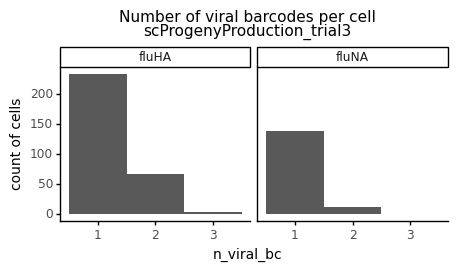

<ggplot: (8740440363963)>

In [23]:
fig = (p9.ggplot(viral_bc_freqs
                 .query('(reject_uninfected == True) and '
                        '(cell_barcode.notna())',
                        engine='python')) +
       p9.geom_histogram(p9.aes(x='n_viral_bc'),
                         binwidth=1,
                         position='dodge') +
       p9.facet_grid('~gene') +
       p9.ggtitle('Number of viral barcodes per cell\n'
                  f'{expt}') +
       p9.xlab('n_viral_bc') +
       p9.ylab('count of cells') +
       p9.theme(figure_size=(5, 2),
                plot_title=p9.element_text(size=11),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

Now I will label cells that have more than 1 viral barcode on a segment.

In [24]:
viral_bc_freqs['gt1_viral_bc'] = (
    viral_bc_freqs['n_viral_bc'] > 1)

viral_bc_freqs

,cell_barcode,infected,infecting_viral_tag,gene,viral_barcode,frac_viral_bc_UMIs,reject_uninfected,freq_progeny,n_cell_bc,gt1_cell,n_viral_bc,gt1_viral_bc
0,AAACCCAGTAACAAGT,False,none,fluHA,NaN,0.0,False,NaN,NaN,False,NaN,False
1,AAACCCATCATTGCTT,False,none,fluHA,NaN,0.0,False,NaN,NaN,False,NaN,False
2,AAACGAAAGATGTTGA,False,none,fluHA,NaN,0.0,False,NaN,NaN,False,NaN,False
3,AAACGAAGTGATAGAT,False,none,fluHA,NaN,0.0,False,NaN,NaN,False,NaN,False
4,AAACGCTCAAATGATG,False,none,fluHA,NaN,0.0,False,NaN,NaN,False,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...
64902,NaN,NaN,wt,fluNA,TTTTTCCCTTACATAT,NaN,NaN,4.799773e-07,NaN,False,NaN,False
64903,NaN,NaN,wt,fluNA,TTTTTCTTACGATCAC,NaN,NaN,4.799773e-07,NaN,False,NaN,False
64904,NaN,NaN,wt,fluNA,TTTTTCTTCGAGATAG,NaN,NaN,4.799773e-06,NaN,False,NaN,False
64905,NaN,NaN,wt,fluNA,TTTTTGGGATCATTGC,NaN,NaN,9.599545e-07,NaN,False,NaN,False


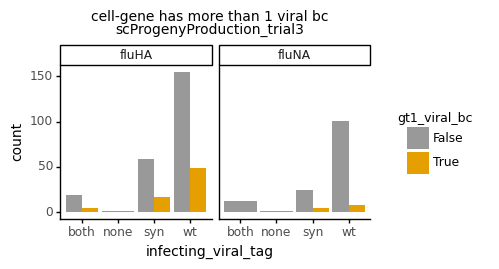

<ggplot: (8740435703495)>

In [25]:
output_fig = (p9.ggplot((viral_bc_freqs
                         .query('(reject_uninfected == True) and '
                                '(cell_barcode.notna())',
                                engine='python')),
                        p9.aes(x='infecting_viral_tag',
                               fill='gt1_viral_bc')) +
              p9.geom_bar(stat='count', position='dodge') +
              p9.ggtitle('cell-gene has more than 1 viral bc\n'
                         f'{expt}') +
              p9.facet_grid('~gene') +
              p9.theme(figure_size=(4, 2),
                       plot_title=p9.element_text(size=10),
                       axis_title=p9.element_text(size=10),
                       legend_title=p9.element_text(size=9),
                       legend_title_align='center') +
              p9.scale_fill_manual(CBPALETTE[0:]))
display(output_fig)

Plot transcriptome-supernatant correlation with this information annotated:

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


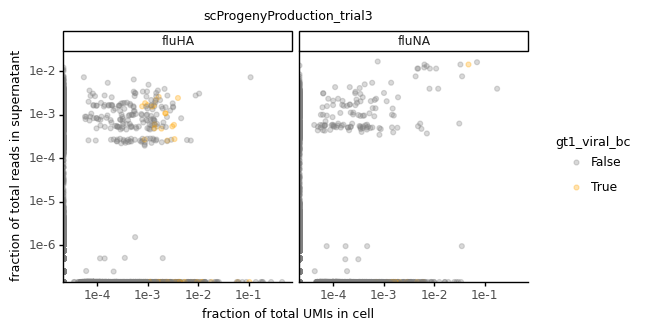

<ggplot: (8740440587680)>

In [32]:
fig = (p9.ggplot(viral_bc_freqs.fillna(0),
                 p9.aes(x='frac_viral_bc_UMIs',
                        y='freq_progeny',
                        color='gt1_viral_bc')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='fraction of total UMIs in cell',
               y='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['grey','orange']))
display(fig)

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


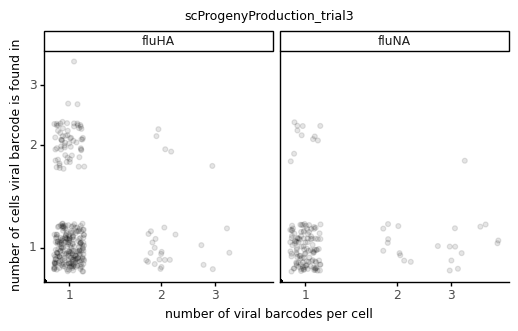

<ggplot: (8740440628962)>

In [38]:
fig = (p9.ggplot(viral_bc_freqs.fillna(0),
                 p9.aes(x='n_cell_bc',
                        y='n_viral_bc')) +
       p9.geom_jitter(alpha=0.1) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='number of viral barcodes per cell',
               y='number of cells viral barcode is found in') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)

In [40]:
test = [None]